In [1]:
# As usual, a bit of setup
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from pydatset.sfddd import get_data, load_imgs
from pydatset.data_augmentation import *
from res_net import ResNet
from pyfunt.solver import Solver as Solver
import os
from pyfunt.utils.vis_utils import visualize_grid
import matplotlib

%matplotlib inline
#matplotlib.style.use('ggplot')


plt.rcParams['figure.figsize'] = (12.0, 7) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data = get_data('/Users/imac/Desktop/r 2')
data['X_val'] = data['X_test']
data['y_val'] = data['y_test']

del data['X_test']
del data['y_test']

classes = range(10)
for k, v in data.iteritems():
  print '%s: ' % k, v.shape if v is not None else None

std:  ()
X_train:  (20424, 3, 48, 48)
X_val:  (2000, 3, 48, 48)
y_val:  (2000,)
y_train:  (20424,)
mean:  (3, 48, 48)


## Training Input Examples

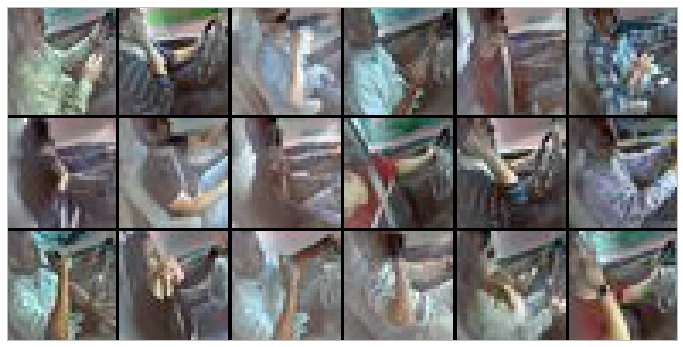

In [4]:


def data_augm(batch):
    h, w = 32, 32
    p = 2
    if batch.shape[-1] is not 32 or batch.shape[-2] is not 32:
        h, w = 32, 32
        ch = (batch.shape[2]-h)/2
        cw = (batch.shape[3]-w)/2
        batch = batch[:, :, ch:-ch, cw:-cw]
    # h, w = XH, XW
    #batch = random_tint(batch, scale=(-.2, 0.2))
    #batch = random_contrast(batch)
    #batch = random_flips(batch)
    #batch = random_rotate(batch, 17.5)
    #batch = random_crops(batch, (h, w), pad=2)
    return batch

N = data['X_train'].shape[0]
d = data['X_train'][np.random.randint(N,size=50)]


grid = visualize_grid(data_augm(d).transpose(0, 2, 3, 1), grid_size=(6, 3))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(grid.astype('uint8'))

#plt.savefig('mini_resnet_overfitting_images.png', dpi=100)


#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
#plt.imshow(grid.astype('uint8'))

Nsize = 3
Results link: https://drive.google.com/open?id=0B8T8Fw0kS2GbUDk4eEoxSS1CcTA

In [17]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

matplotlib.rcParams.update({'font.size': 13})


def show_all(loss, tr_err, val_err, ylim1=None, ylim2=None):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)
    
    
    ax1 = plt.plot(loss)
    plt.setp(ax1, color='#ff4040')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.xlabel('iterazione')

    ax = plt.subplot(gs1[1])#2, 1, 2)
    ax1 = plt.plot(tr_err)
    plt.setp(ax1, color='#ff4040')

    ax1 = plt.plot(val_err)
    
    plt.setp(ax1, color='#104E8B')
    
    if ylim2: ax.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.legend(['train', 'val'], loc='upper right')
    gs1.tight_layout(fig)
    
def show_loss(loss, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(loss, columns=['loss'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    
def show_train_val(tr_err, val_err, ylim=None):
    print '## Training and Validation error'
    ts = pd.DataFrame(zip(tr_err, val_err), columns=['train', 'val'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    
def show_weights(exp):
    print '## Weights visualization'
    plt.grid(True, color='w', linestyle='-', linewidth=0)
    w = np.load('../Experiments/%s/model.npy' % exp).item()['W1']

    grid = visualize_grid(w.transpose(0, 2, 3, 1))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.imshow(1-grid.squeeze())
    
    
def show_err_comp(errs, names, losses=None, ylim=None):
    print '## Error Comparision'
    #ts = pd.DataFrame(zip(*errs), columns=names)


    ax = plt.plot(errs[0])
    #ax = ts.plot(style=['-', '--', '-', '--'])
    plt.setp(ax, color='#104E8B', ls='-')
    ax = plt.plot(errs[1])
    plt.setp(ax, color='#104E8B', ls='--')
    ax = plt.plot(errs[2])
    plt.setp(ax, color='#ff4040',ls='-')
    ax = plt.plot(errs[3])
    plt.setp(ax, color='#ff4040',ls='--')
    plt.legend(names, loc='upper right')


    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()

        
def show_loss_comp(losses, names, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(zip(*losses), columns=names)
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    plt.show()
    
    
def show_all_comp(losses, loss_names, errs, err_names, colors, ylim1=False, ylim2=False):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)

    for i, loss in enumerate(losses):
        ax1 = plt.plot(loss)
        plt.setp(ax1, color=colors[i % len(colors)])
        
    plt.legend(loss_names, loc='upper right')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.xlabel('iterazione')
    ax1 = plt.subplot(gs1[1])#2, 1, 2)
    
    for i in range(0, len(errs)-1, 2):
        
        ax = plt.plot(errs[i + 0])
        plt.setp(ax, color=colors[i/2], ls='-')
        ax = plt.plot(errs[i + 1])
        plt.setp(ax, color=colors[i/2], ls='--')

    if ylim2: ax1.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()
    
    
    
def results_for_exp(exp):
    loss = moving_average(np.load('../Experiments/%s/loss.npy' % exp), n=200)
    tr_acc = np.loadtxt('../Experiments/%s/train_acc_history.csv' % exp, delimiter=',')[:,-1]
    val_acc = np.loadtxt('../Experiments/%s/val_acc_history.csv' % exp, delimiter=',')[:,-1]
    tr_err = 1 - tr_acc
    val_err = 1 - val_acc
    return loss, tr_err, val_err
    

## Experiment 6c32de48eb

Nsize = 3, N starting filters: 16 

Dataset images resized and scaled to 32x32 using [this little script](https://gist.github.com/dnlcrl/e2e25f7989e394580cab33138add2c43)

Results link: https://drive.google.com/open?id=0B8T8Fw0kS2GbcjY3c1FjRlhyV28

## Total training loss and train/ val errors


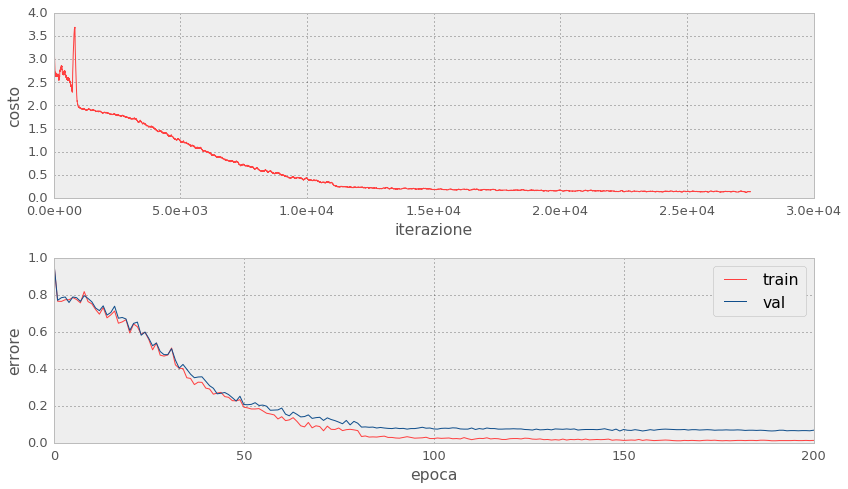

In [11]:
loss, tr_err, val_err = results_for_exp('6c32de48eb')
show_all(loss, tr_err, val_err, ylim1=False, ylim2=False)

## Weights visualization


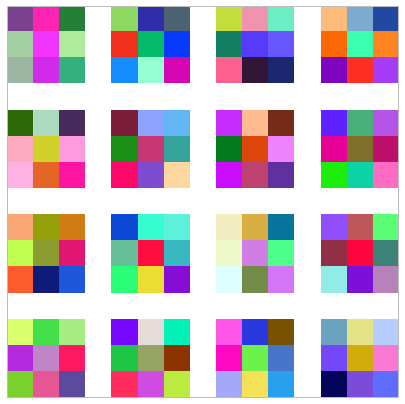

In [12]:
show_weights('6c32de48eb')

In [13]:
# train
exp = '6c32de48eb'

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(3, input_dim=(1, 32, 32),num_starting_filters=16)

solver = Solver(res_net)
solver.model.params = np.load('../Experiments/%s/model.npy' % exp).item()

print data['X_val'].shape
if data['X_val'].shape[-1] == 48:
    samples = random_crops(data['X_val'], (32, 32), pad=0)
else:
    samples = data['X_val']
predictions = solver.check_accuracy(samples, data['y_val'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_val'])

Accuracy Check: 100%|██████████| 2000/2000 [00:31<00:00, 65.29im/s]

(2000, 3, 48, 48)

Accuracy: 0.756000


# f0e4a0412a

## Total training loss and train/ val errors


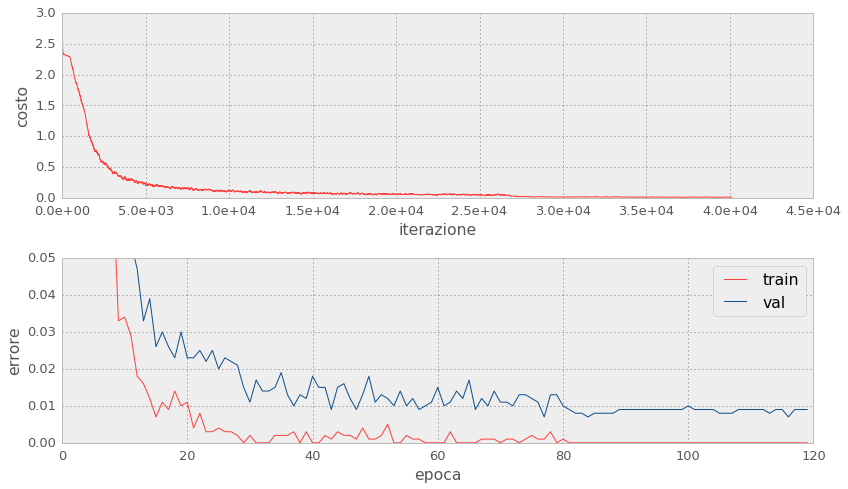

In [74]:
loss, tr_err, val_err = results_for_exp('f0e4a0412a')
show_all(loss, tr_err, val_err, ylim1=False, ylim2=(0.0, 0.05))

In [41]:
# train
exp = 'f0e4a0412a'

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(5, input_dim=(3, 32, 32),num_starting_filters=16)

solver = Solver(res_net, num_processes=1)
solver.model.params = np.load('../Experiments/%s/model.npy' % exp).item()

if data['X_val'].shape[-1] is not 32:
    h, w = 32, 32
    ch = (data['X_val'].shape[2]-h)/2
    cw = (data['X_val'].shape[3]-w)/2
    samples = data['X_val'][:, :, ch:-ch, cw:-cw]
else:
    samples = data['X_val']
print samples.shape

predictions = solver.check_accuracy(samples, data['y_val'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_val'])

Accuracy Check:   0%|          | 0/2000 [00:00<?, ?im/s]

(2000, 3, 32, 32)


KeyboardInterrupt: 

# d2fc68b94a

## Total training loss and train/ val errors


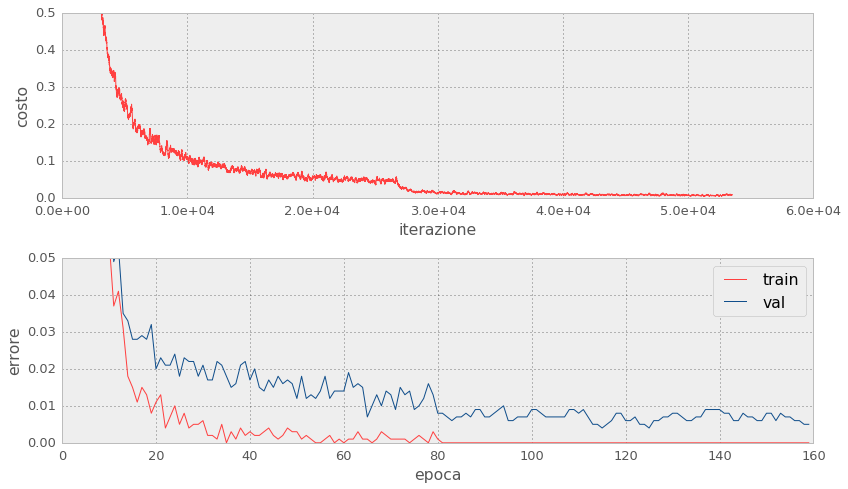

In [29]:
loss, tr_err, val_err = results_for_exp('d2fc68b94a')
show_all(loss, tr_err, val_err, ylim1=(0.0, 0.5), ylim2=(0.0, 0.05))

In [25]:
# train
exp = 'd2fc68b94a'

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(7, input_dim=(3, 32, 32),num_starting_filters=16)

solver = Solver(res_net, num_processes=1)
solver.model.params = np.load('../Experiments/%s/model.npy' % exp).item()

if data['X_val'].shape[-1] is not 32:
    h, w = 32, 32
    ch = (data['X_val'].shape[2]-h)/2
    cw = (data['X_val'].shape[3]-w)/2
    samples = data['X_val'][:, :, ch:-ch, cw:-cw]
else:
    samples = data['X_val']
print samples.shape

predictions = solver.check_accuracy(samples, data['y_val'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_val'])

Accuracy Check: 100%|██████████| 2000/2000 [01:59<00:00, 17.09im/s]

(2000, 3, 32, 32)

Accuracy: 0.997500


## Total training loss and train/ val errors


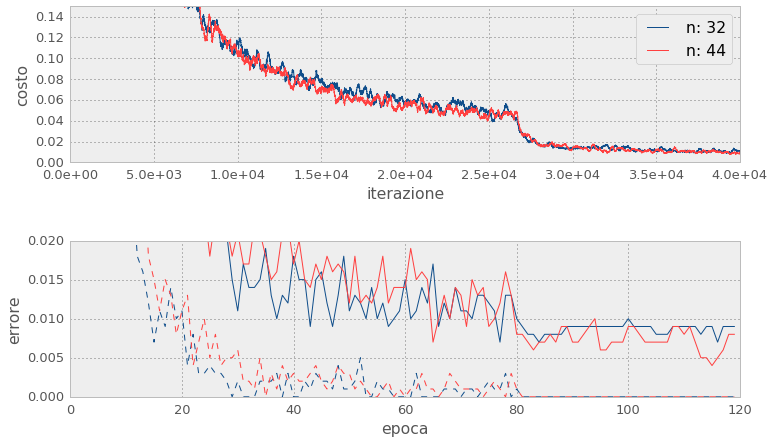

In [19]:
colors = ['#104E8B', '#ff4040']
losses_names = ('n: 32', 'n: 44')

err_names = ('', '', '1 (val)', '1 (train)',  '3 (val)', '3 (train)')


loss2, tr_err1, val_err1 = results_for_exp('d2fc68b94a')
loss1, tr_err2, val_err2 = results_for_exp('f0e4a0412a')


#show_loss_comp((loss1, loss2), ['non residual', 'residual'])

losses = (loss1, loss2[:len(loss1)])
errs = (val_err2, tr_err2, val_err1[:len(val_err2)], tr_err1[:len(tr_err2)])
show_all_comp(losses , losses_names, errs, err_names, colors, ylim1=(0,0.15), ylim2=(0,0.02))


# Visualize Saliency Maps

[original source: http://cs231n.github.io]

Visualize Saliency Maps
In a recent paper [1], it was suggested that you can understand which part of an image is important for classification by visualizing the gradient of the correct class score with respect to the input image. This was covered in lecture on 2/2/2015 under the section "Visualize the data gradient". Recall that if a region of the image has a high data gradient, then this indicates that the output of the ConvNet is sensitive to perturbations in that region of the input image.

We will do something similar, instead visualizing the gradient of the data loss with respect to the input image.

[1] K. Simonyan, A. Vedaldi, A. Zisserman , "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014

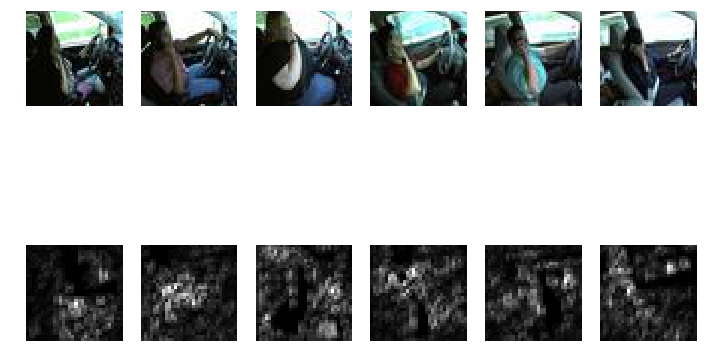

In [43]:
def show_image(img, rescale=False, add_mean=True):
    """
    Utility to show an image. In our ConvNets, images are 3D slices of 4D
    volumes; to visualize them we need to squeeze out the extra dimension,
    flip the axes so that channels are last, add the mean image, convert to
    uint8, and possibly rescale to be between 0 and 255. To make figures
    prettier we also need to suppress the axis labels after imshow.
    
    Input:
    - img: (1, C, H, W) or (C, H, W) or (1, H, W) or (H, W) giving
      pixel data for an image.
    - rescale: If true rescale the data to fit between 0 and 255
    - add_mean: If true add the training data mean image
    """
    img = img.copy()
    if add_mean:
        #
        img *= data['std']
        img += data['mean']
    img = img.squeeze()
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)
    if rescale:
        low, high = np.min(img), np.max(img)
        img = 255.0 * (img - low) / (high - low)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

X_val = data['X_val']
y_val = data['y_val']
# The number of example images to show. You can change this.
num_examples = 6

# The label of the class to visualize. You can change this.
class_idx = 2 # 


# Choose several examples from the validation set whose correct label is
# class_idx and which are correctly classified by the pretrained ConvNet.
good_points = np.logical_and((predictions == y_val), (y_val == class_idx))
available_idxs, = np.nonzero(good_points)
example_idxs = available_idxs[0:num_examples]

# Compute loss gradients
samples = random_crops(X_val[example_idxs], (32, 32), pad=0)
dX = res_net.loss(samples, y_val[example_idxs], compute_dX=True, return_probs=False)

# Plot the images and their saliency maps.
for i in xrange(num_examples):
    # Visualize the image
    plt.subplot(2, num_examples, i + 1)
    show_image(X_val[example_idxs[i]])
    #plt.title(class_names[y_val[example_idxs[i]]][0])
    
    # Saliency map for the ith example image.
    sal = np.zeros((32, 32))

    sal = np.max(np.abs(dX[i]), axis = 0)
    
    plt.subplot(2, num_examples, num_examples + i + 1)
    show_image(sal, rescale=True, add_mean=False)
    

In [27]:
# read test data from CSV file 
root = '/Users/imac/Desktop/r'
xs = []
xs.append(load_imgs(os.path.join(root, 'test')))
Xte = np.concatenate(xs).astype(np.float64).transpose(0, 3, 1, 2)
print Xte.shape
Xte = (Xte - data['mean'])/data['std']
if Xte.shape[-1] is not 32:
    h, w = 32, 32
    ch = (Xte.shape[2]-h)/2
    cw = (Xte.shape[3]-w)/2
    samples = Xte[:, :, ch:-ch, cw:-cw]

ERROR! Session/line number was not unique in database. History logging moved to new session 101
(79726, 3, 48, 64)


In [75]:
probabilities = solver.check_accuracy(samples, return_probs=True)

Accuracy Check: 79800im [44:56, 39.84im/s]                           